In [ ]:
# Install necessary packages
!pip install tensorflow scikit-learn onnx tf2onnx

# Import libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import onnx
import tf2onnx
from tensorflow import keras

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define paths
dataset_dir = "/content/drive/MyDrive/drowsiness_detection/dataset_25"
model_save_path = "/content/drive/MyDrive/notebook_results/drowsiness_detection/drowsiness_detection_model.h5"
onnx_model_save_path = "/content/drive/MyDrive/notebook_results/drowsiness_detection/drowsiness_detection_model.onnx"

In [3]:
# Create data generator
datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

In [4]:
# Create data generators
batch_size = 64

data_generator = datagen.flow_from_directory(dataset_dir,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            subset='training')

validation_generator = datagen.flow_from_directory(dataset_dir,
                                                   target_size=(224, 224),
                                                   batch_size=batch_size,
                                                   class_mode='binary',
                                                   subset='validation')

Found 16981 images belonging to 2 classes.
Found 4244 images belonging to 2 classes.


In [5]:
# Create MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Create custom model
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
# Callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_save_path, save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.CSVLogger('training_log.csv')
]

In [10]:
# Training the model
epochs = 20

history = model.fit(data_generator,
                    steps_per_epoch=data_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/20
265/265 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.8856 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


265/265 [==============================] - 7410s 28s/step - loss: 0.2813 - accuracy: 0.8856 - val_loss: 0.3409 - val_accuracy: 0.8591
Epoch 2/20
265/265 [==============================] - 372s 1s/step - loss: 0.1803 - accuracy: 0.9341 - val_loss: 0.3030 - val_accuracy: 0.8741
Epoch 3/20
265/265 [==============================] - 335s 1s/step - loss: 0.1569 - accuracy: 0.9436 - val_loss: 0.2840 - val_accuracy: 0.8849
Epoch 4/20
265/265 [==============================] - 349s 1s/step - loss: 0.1441 - accuracy: 0.9488 - val_loss: 0.3079 - val_accuracy: 0.8755
Epoch 5/20
265/265 [==============================] - 350s 1s/step - loss: 0.1332 - accuracy: 0.9525 - val_loss: 0.2851 - val_accuracy: 0.8835
Epoch 6/20
265/265 [==============================] - 336s 1s/step - loss: 0.1300 - accuracy: 0.9550 - val_loss: 0.3002 - val_accuracy: 0.8790
Epoch 7/20
265/265 [==============================] - 336s 1s/step - loss: 0.1235 - accuracy: 0.9576 - val_loss: 0.2827 - val_accuracy: 0.8838
Epoch 8/

In [11]:
# Load the TensorFlow model from the .h5 file
#model_path = '/content/drive/MyDrive/notebook_results/drowsiness_detection.h5'
model = tf.keras.models.load_model(model_save_path)

# Convert the TensorFlow model to ONNX
onnx_model, _ = tf2onnx.convert.from_keras(model)

# Save the ONNX model to a file
#onnx_file_path = '/content/drive/MyDrive/notebook_results/drowsiness_detection.onnx'
with open(onnx_model_save_path, 'wb') as f:
    f.write(onnx_model.SerializeToString())

print(f"ONNX model successfully saved at: {onnx_model_save_path}")

ONNX model successfully saved at: /content/drive/MyDrive/notebook_results/drowsiness_detection/drowsiness_detection_model.onnx


In [12]:
# Evaluate the model
predictions = model.predict(validation_generator)
y_true = validation_generator.classes
y_pred = np.round(predictions).reshape((1, -1))[0]

67/67 [==============================] - 68s 1s/step


In [13]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

In [14]:
# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['Closed_Eyes', 'Opened_Eyes'])

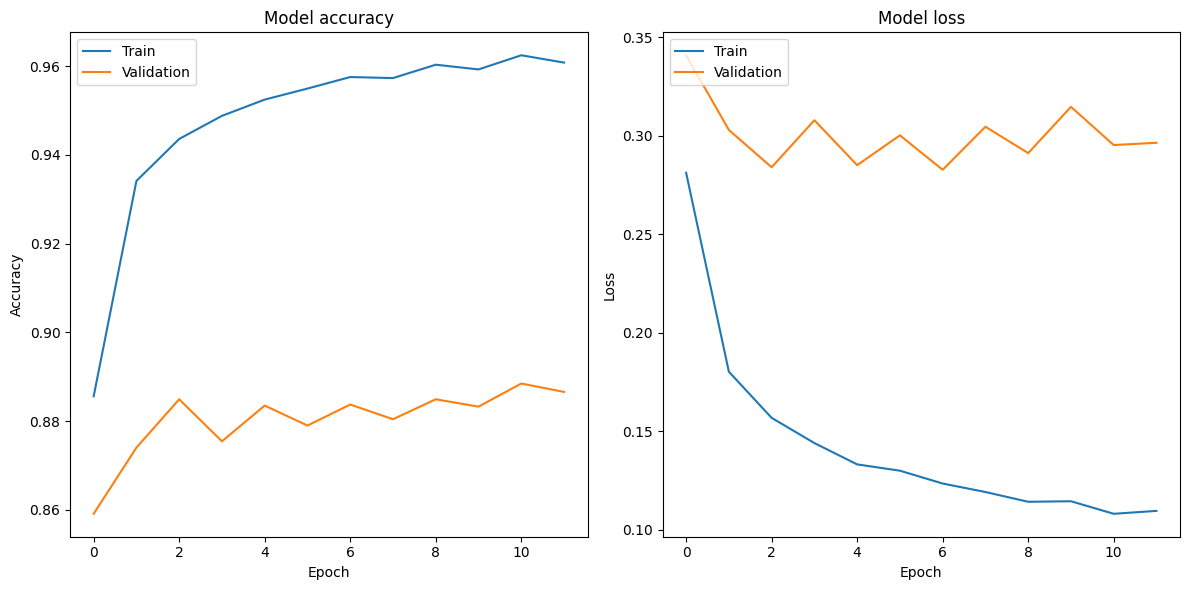

In [15]:
# Plotting the training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [16]:
# Print evaluation results
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[1201  896]
 [1213  934]]

Classification Report:
              precision    recall  f1-score   support

 Closed_Eyes       0.50      0.57      0.53      2097
 Opened_Eyes       0.51      0.44      0.47      2147

    accuracy                           0.50      4244
   macro avg       0.50      0.50      0.50      4244
weighted avg       0.50      0.50      0.50      4244

